<a href="https://colab.research.google.com/github/whtns/todo/blob/main/_downloads/76d764ad694d0795e494a1edbfb068a6/buildmodel_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For tips on running notebooks in Google Colab, see
# https://docs.pytorch.org/tutorials/beginner/colab
%matplotlib inline

[Learn the Basics](intro.html) \|\|
[Quickstart](quickstart_tutorial.html) \|\|
[Tensors](tensorqs_tutorial.html) \|\| [Datasets &
DataLoaders](data_tutorial.html) \|\|
[Transforms](transforms_tutorial.html) \|\| **Build Model** \|\|
[Autograd](autogradqs_tutorial.html) \|\|
[Optimization](optimization_tutorial.html) \|\| [Save & Load
Model](saveloadrun_tutorial.html)

Build the Neural Network
========================

Neural networks comprise of layers/modules that perform operations on
data. The [torch.nn](https://pytorch.org/docs/stable/nn.html) namespace
provides all the building blocks you need to build your own neural
network. Every module in PyTorch subclasses the
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
A neural network is a module itself that consists of other modules
(layers). This nested structure allows for building and managing complex
architectures easily.

In the following sections, we\'ll build a neural network to classify
images in the FashionMNIST dataset.


In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Get Device for Training
=======================

We want to be able to train our model on an
[accelerator](https://pytorch.org/docs/stable/torch.html#accelerators)
such as CUDA, MPS, MTIA, or XPU. If the current accelerator is
available, we will use it. Otherwise, we use the CPU.


⚠️ should add info about selecting device in colab?

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Define the Class
================

We define our neural network by subclassing `nn.Module`, and initialize
the neural network layers in `__init__`. Every `nn.Module` subclass
implements the operations on input data in the `forward` method.


In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of `NeuralNetwork`, and move it to the `device`,
and print its structure.


In [5]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model\'s
`forward`, along with some [background
operations](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866).
Do not call `model.forward()` directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0
corresponding to each output of 10 raw predicted values for each class,
and dim=1 corresponding to the individual values of each output. We get
the prediction probabilities by passing it through an instance of the
`nn.Softmax` module.


In [6]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([3], device='cuda:0')


------------------------------------------------------------------------


Model Layers
============

Let\'s break down the layers in the FashionMNIST model. To illustrate
it, we will take a sample minibatch of 3 images of size 28x28 and see
what happens to it as we pass it through the network.


In [8]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


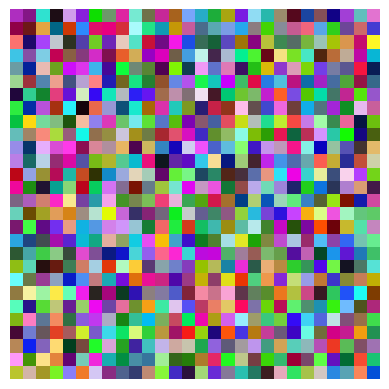

In [15]:
import matplotlib.pyplot as plt
# input_image
np_image = input_image.permute(1, 2, 0).numpy()
plt.imshow(np_image)
plt.axis('off') # Optional: to hide axes
plt.show()

nn.Flatten
==========

We initialize the
[nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)
layer to convert each 2D 28x28 image into a contiguous array of 784
pixel values ( the minibatch dimension (at dim=0) is maintained).


In [16]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())
print(flat_image)

torch.Size([3, 784])
tensor([[0.6859, 0.5183, 0.1871,  ..., 0.3509, 0.9847, 0.0135],
        [0.1843, 0.0865, 0.8897,  ..., 0.6431, 0.5220, 0.3156],
        [0.7525, 0.5288, 0.8191,  ..., 0.7080, 0.3528, 0.8497]])


nn.Linear
=========

The [linear
layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
is a module that applies a linear transformation on the input using its
stored weights and biases.

⚠️ what does this mean?


In [18]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


nn.ReLU
=======

Non-linear activations are what create the complex mappings between the
model\'s inputs and outputs. They are applied after linear
transformations to introduce *nonlinearity*, helping neural networks
learn a wide variety of phenomena.

In this model, we use
[nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
between our linear layers, but there\'s other activations to introduce
non-linearity in your model.


In [19]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[-0.9949, -0.3047,  0.3443,  0.2711,  0.1916, -0.3508, -0.2052, -0.2979,
         -0.2884,  0.1363,  0.5413, -0.6967,  0.0454,  0.4007,  0.1677, -0.0142,
         -0.0217, -0.0190,  0.0430, -0.2837],
        [-0.9605, -0.5273,  0.1533, -0.4042,  0.1905, -0.1410,  0.4076, -0.2503,
         -0.8935, -0.1292,  0.5803, -0.6705,  0.1102,  0.3701,  0.4705, -0.0254,
          0.2591, -0.0347, -0.0231,  0.0952],
        [-0.9565, -0.4618,  0.0389,  0.0223,  0.3208, -0.0744, -0.1652, -0.5341,
         -0.5374,  0.2226,  0.4432, -0.5884,  0.1022,  0.6443,  0.0181,  0.0886,
          0.1084, -0.1120, -0.0157, -0.2241]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.0000, 0.3443, 0.2711, 0.1916, 0.0000, 0.0000, 0.0000, 0.0000,
         0.1363, 0.5413, 0.0000, 0.0454, 0.4007, 0.1677, 0.0000, 0.0000, 0.0000,
         0.0430, 0.0000],
        [0.0000, 0.0000, 0.1533, 0.0000, 0.1905, 0.0000, 0.4076, 0.0000, 0.0000,
         0.0000, 0.5803, 0.0000, 0.1102, 0.3701, 0.47

nn.Sequential
=============

[nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
is an ordered container of modules. The data is passed through all the
modules in the same order as defined. You can use sequential containers
to put together a quick network like `seq_modules`.


In [20]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

nn.Softmax
==========

The last linear layer of the neural network returns [logits]{.title-ref}
- raw values in \[-infty, infty\] - which are passed to the
[nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
module. The logits are scaled to values \[0, 1\] representing the
model\'s predicted probabilities for each class. `dim` parameter
indicates the dimension along which the values must sum to 1.

⚠️ .title-ref formatting broken


In [22]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

Model Parameters
================

Many layers inside a neural network are *parameterized*, i.e. have
associated weights and biases that are optimized during training.
Subclassing `nn.Module` automatically tracks all fields defined inside
your model object, and makes all parameters accessible using your
model\'s `parameters()` or `named_parameters()` methods.

In this example, we iterate over each parameter, and print its size and
a preview of its values.


In [21]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0114,  0.0098,  0.0198,  ..., -0.0129, -0.0020,  0.0339],
        [ 0.0163,  0.0045,  0.0060,  ...,  0.0009,  0.0339,  0.0173]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0081, -0.0051], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0370, -0.0184,  0.0265,  ...,  0.0308, -0.0013,  0.0019],
        [ 0.0333, -0.0143, -0.0433,  ..., -0.0172,  0.0418,  0.0309]],
       device='cuda:0', grad_fn=<Sl

------------------------------------------------------------------------


Further Reading
===============

-   [torch.nn API](https://pytorch.org/docs/stable/nn.html)
